In [41]:
import pandas as pd 
import functools 
import itertools
from shortuuid import uuid
from Bio import Phylo 
from matplotlib import pyplot as plt
from scripts.lib.quartet_edge_support import (
    set_tree_ids,
    root_at_internal_node,
    calculate_edge_support,
)

In [42]:
import scripts
scripts.__path__

['/projects/illinois/eng/cs/warnow/zxliu2/OneMostProb/scripts']

In [43]:
plt.rcParams['figure.dpi'] = 150 # better resolution when showing and saving
plt.rcParams["savefig.dpi"] = 150

## Quartet Edge Support

In [44]:
from scripts.lib.getQuartets import get_quartets_names_ret_values
from scripts.lib.utils import get_values
import pandas as pd

Change the below variables to configure the tree and character set (CSV).

In [ ]:
TREE_FILE = "/projects/illinois/eng/cs/warnow/zxliu2/OneMostProb/outputs/rt_poly_2025_weighted/rt_2025_poly_screened_lv_0_weighted/ASTRAL(11,5)/trees/output.tree"
DATA_FILE = "/projects/illinois/eng/cs/warnow/zxliu2/OneMostProb/example/rt_2025_poly/rt_2025_poly_screened_lv_0.csv"
TREE_FORMAT = "newick"
QUARTET_MODE = 11

`quartet_edge_support` is a map of (edge, character name) -> list of quartets

In [49]:
rt_tree = Phylo.read(file=TREE_FILE, format=TREE_FORMAT)

root_at_internal_node(rt_tree)
set_tree_ids(rt_tree)
dataset_csv_path = DATA_FILE
names, values = get_values(dataset_csv_path)
chr_names = pd.read_csv(dataset_csv_path).values[:, :2]

quartet_edge_support = {}

for character, chr_name in zip(values, chr_names):
    assert(len(character) == len(names))
    _, quartets = get_quartets_names_ret_values(
        names=names,
        ret_values = [character],
        mode=QUARTET_MODE,
        do_filter = False,
        filter_lim=0
    )
    edge_support = calculate_edge_support(
        tree=rt_tree, 
        quartets=quartets 
    )
    for edge, quartets in edge_support.items():
        quartet_edge_support.setdefault(edge, {})
        quartet_edge_support[edge][chr_name[0]] = quartets


In [50]:
for edge, chrs in quartet_edge_support.items():
    if(len(chrs) <= 5):
        total_quartets_supporting_edge = sum([len(q) for _, q in chrs.items()])
        print(f"{edge}: supported by {total_quartets_supporting_edge} quartets, {chrs}")
    total_quartets_supporting_edge = sum([len(q) for _, q in chrs.items()])
    print(f"{edge}: supported by {len(chrs)} characters {total_quartets_supporting_edge} quartets, {chrs.keys()}")
        

('i003', 'i029'): supported by 12 characters 192 quartets, dict_keys(['a1001', 'a45', 'a70', 'a89', 'a111', 'a115', 'a143', 'a170', 'a180', 'a189', 'a352', 'a421'])
('i033', 'i035'): supported by 38 quartets, {'a1001': [('LA', 'WE', 'OS', 'UM'), ('LA', 'OI', 'OS', 'UM')], 'a1022': [('LA', 'WE', 'OS', 'UM'), ('LA', 'PR', 'OS', 'UM'), ('LA', 'OE', 'OS', 'UM'), ('LA', 'LY', 'OS', 'UM'), ('LA', 'LI', 'OS', 'UM'), ('LA', 'OI', 'OS', 'UM'), ('LA', 'LU', 'OS', 'UM'), ('LA', 'VE', 'OS', 'UM'), ('AR', 'LA', 'OS', 'UM'), ('HI', 'LA', 'OS', 'UM'), ('GK', 'LA', 'OS', 'UM'), ('LA', 'PE', 'OS', 'UM'), ('LA', 'OC', 'OS', 'UM'), ('GO', 'LA', 'OS', 'UM'), ('LA', 'TB', 'OS', 'UM'), ('LA', 'TA', 'OS', 'UM'), ('AV', 'LA', 'OS', 'UM'), ('LA', 'OG', 'OS', 'UM'), ('LA', 'ON', 'OS', 'UM'), ('LA', 'LT', 'OS', 'UM')], 'a1037': [('GK', 'LA', 'OS', 'UM'), ('LA', 'ON', 'OS', 'UM'), ('LA', 'WE', 'OS', 'UM'), ('LA', 'PR', 'OS', 'UM'), ('LA', 'OI', 'OS', 'UM'), ('LA', 'PE', 'OS', 'UM'), ('LA', 'VE', 'OS', 'UM'), ('AR

In [51]:
quartet_edge_support_cnts = {
    a: len(b) for a, b in quartet_edge_support.items()
}

In [52]:
len(quartet_edge_support_cnts)

20

In [53]:
def update_tree_branch_lengths(
    tree: Phylo.BaseTree.TreeMixin,
    quartet_edge_support_cnts: dict[(str, str), int]
): 
    for clade in tree.find_clades():
        u = clade.parent
        v = clade.id
        support = quartet_edge_support_cnts.get((u, v)) or 0
        setattr(clade, 'quartet_support', support)
        clade.branch_length = 1


In [54]:
update_tree_branch_lengths(rt_tree, quartet_edge_support_cnts)

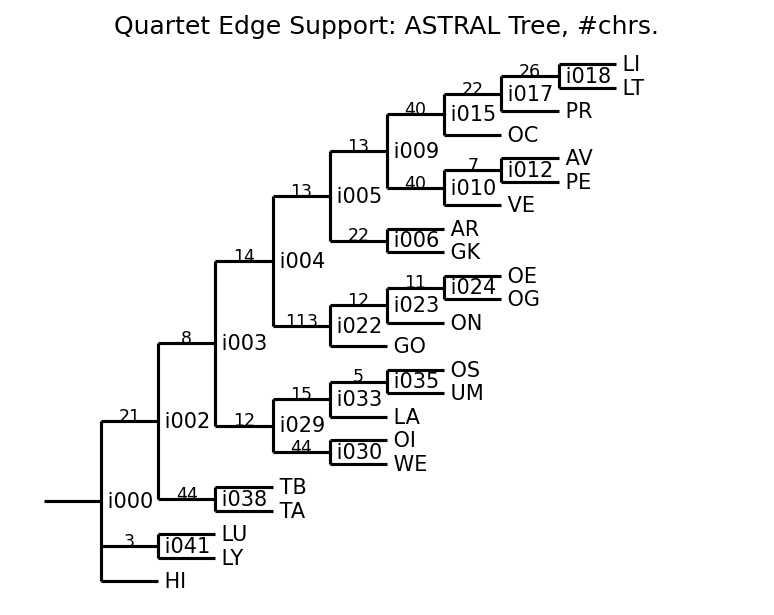

In [55]:
# rt_tree.root_with_outgroup(['PROTO', 'BURG', 'GO'])

rt_tree.ladderize(reverse=True)


axes = plt.subplot()

Phylo.draw(rt_tree, axes=axes, 
    branch_labels= lambda c : getattr(c, 'quartet_support', 0), 
    label_func = lambda c : c.name if c.name else c.id,
    do_show=False
)
plt.title(f'Quartet Edge Support: ASTRAL Tree, #chrs.')
plt.axis('off')
plt.show()

## Which quartets/characters support which edges
- The following code prints, for each edge, the number of characters that support it and which characters they are. 
- If there are not more than 5 characters supporting that edge, 

In [56]:
for edge, chrs in quartet_edge_support.items():
    total_quartets_supporting_edge = sum([len(q) for _, q in chrs.items()])
    print(f"{edge}:\n\t- supported by {len(chrs)} characters (total {total_quartets_supporting_edge} quartets), \n\t- supporting characters = {list(chrs.keys())}")
    if(len(chrs) <= 5):
        total_quartets_supporting_edge = sum([len(q) for _, q in chrs.items()])
        print(f"{edge}: supported by {total_quartets_supporting_edge} quartets, supporting characters = {chrs}")


('i003', 'i029'):
	- supported by 12 characters (total 192 quartets), 
	- supporting characters = ['a1001', 'a45', 'a70', 'a89', 'a111', 'a115', 'a143', 'a170', 'a180', 'a189', 'a352', 'a421']
('i033', 'i035'):
	- supported by 5 characters (total 38 quartets), 
	- supporting characters = ['a1001', 'a1022', 'a1037', 'a11', 'a28']
('i033', 'i035'): supported by 38 quartets, supporting characters = {'a1001': [('LA', 'WE', 'OS', 'UM'), ('LA', 'OI', 'OS', 'UM')], 'a1022': [('LA', 'WE', 'OS', 'UM'), ('LA', 'PR', 'OS', 'UM'), ('LA', 'OE', 'OS', 'UM'), ('LA', 'LY', 'OS', 'UM'), ('LA', 'LI', 'OS', 'UM'), ('LA', 'OI', 'OS', 'UM'), ('LA', 'LU', 'OS', 'UM'), ('LA', 'VE', 'OS', 'UM'), ('AR', 'LA', 'OS', 'UM'), ('HI', 'LA', 'OS', 'UM'), ('GK', 'LA', 'OS', 'UM'), ('LA', 'PE', 'OS', 'UM'), ('LA', 'OC', 'OS', 'UM'), ('GO', 'LA', 'OS', 'UM'), ('LA', 'TB', 'OS', 'UM'), ('LA', 'TA', 'OS', 'UM'), ('AV', 'LA', 'OS', 'UM'), ('LA', 'OG', 'OS', 'UM'), ('LA', 'ON', 'OS', 'UM'), ('LA', 'LT', 'OS', 'UM')], 'a1037

In [ ]:
print(rt_tree)

Tree(rooted=False, weight=1.0)
    Clade(branch_length=1, dep=0, id='i000', l=1, parent='i000', quartet_support=0, r=34)
        Clade(branch_length=1, dep=1, id='i002', l=4, parent='i000', quartet_support=0, r=33)
            Clade(branch_length=1, confidence=0.96, dep=2, id='i004', l=7, parent='i002', quartet_support=5, r=32)
                Clade(branch_length=1, confidence=0.93, dep=3, id='i006', l=10, parent='i004', quartet_support=9, r=31)
                    Clade(branch_length=1, confidence=1, dep=4, id='i007', l=11, parent='i006', quartet_support=12, r=28)
                        Clade(branch_length=1, confidence=1, dep=5, id='i009', l=14, parent='i007', quartet_support=94, r=27)
                            Clade(branch_length=1, confidence=0.88, dep=6, id='i011', l=17, parent='i009', quartet_support=34, r=26)
                                Clade(branch_length=1, confidence=1, dep=7, id='i013', l=20, parent='i011', quartet_support=38, r=25)
                                   

: 

: 

: 

: 

: 

: 